In [7]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [263]:

import pathlib
import IPython
import random
import shutil
import matplotlib.pyplot as plt
import skimage
import matplotlib
import cv2

PATH = pathlib.Path.cwd()
DATA_PATH = PATH.parent / "data"

# DexiNed Edge Detection

First we use DexiNed for edge detection, transforming our frogs into black and white outlines.

https://github.com/xavysp/DexiNed/tree/master/DexiNed-TF2

<code>python src/DexiNed-TF2/main.py --model_state="test" --test_dir="data/raw/data-224" --output_dir="data/interim" --checkpoint_dir="src/DexiNed-TF2" --checkpoint="DexiNed23_model.h5" --test_img_height=224 --test_img_width=224 --test_bs=32</code>

DexiNed outputs 3 files per input file but we only care about the fused image. Below we will move this files and delete the rest.

In [5]:
# in python 3.8, shutil.move will not accept pathlike objects
source_dir = (DATA_PATH / "interim" / "DexiNed-BIPED2CLASSIC" / "fuse").__str__()
target_dir = (DATA_PATH / "interim" / "DexiNed-fuse").__str__()

# make a folder to put the files
if not os.path.exists(target_dir):
    os.mkdir(DATA_PATH / "interim" / "DexiNed-fuse")

file_names = os.listdir(source_dir)

for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [7]:
# remove unwanted files
shutil.rmtree(DATA_PATH / "interim" / "DexiNed-BIPED2CLASSIC")

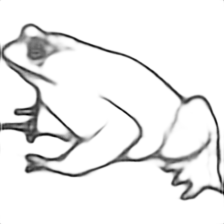

In [3]:
filepaths = [x for x in DATA_PATH.glob('interim/DexiNed-fuse/*.png')]

IPython.display.Image(filename=random.choice(filepaths))

# Canny Edge Detection

This has done a great job, but the outlines are much more complicated than a user would be expected to draw. So to further simplify the images we will pass them through a canny edge detection algorithm.

We can also observe top and bottom border lines in many images where the clearly the source didn't have a completely white background.

Finally some outlines inclkude the outline of a shadow under the frog, we may be able to remove these with the canny edge detector.

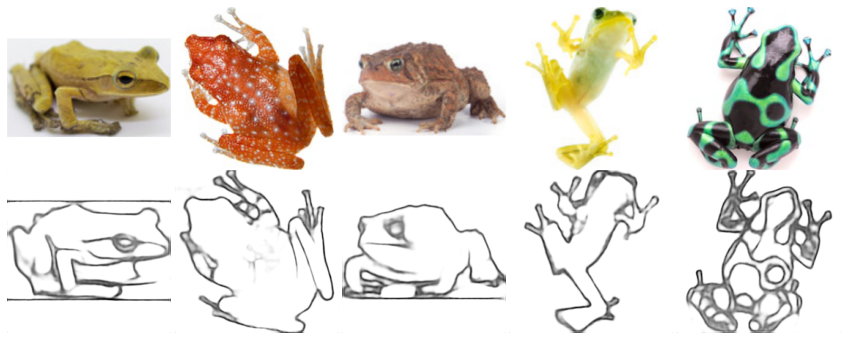

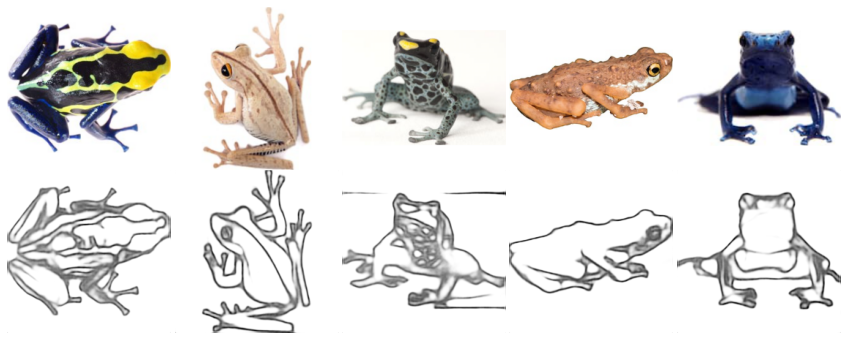

In [81]:
def show_DexiNed_sketches(n=5, size=3):
    """Prints a sample of random frogs and their DexiNed generated sketches"""
    # prepare figure
    fig, axs = plt.subplots(2, n, figsize=(size*n, size*2))

    # plot sketch and source
    for image_ax, sketch_ax in zip(axs[0], axs[1]):
        # get filepaths
        sketch_path = random.choice(filepaths)
        image_path = sketch_path.__str__().replace('interim\\DexiNed-fuse', 'raw\\data-224')
        # read file and plot
        sketch_ax.imshow(plt.imread(sketch_path), cmap='gray')        
        image_ax.imshow(plt.imread(image_path))
    
    # remove axis ticks
    for ax in matplotlib.cbook.flatten(axs):
        ax.axis('off')
    
    # adjust styling and show
    fig.patch.set_facecolor('white')      
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
show_DexiNed_sketches()
show_DexiNed_sketches()

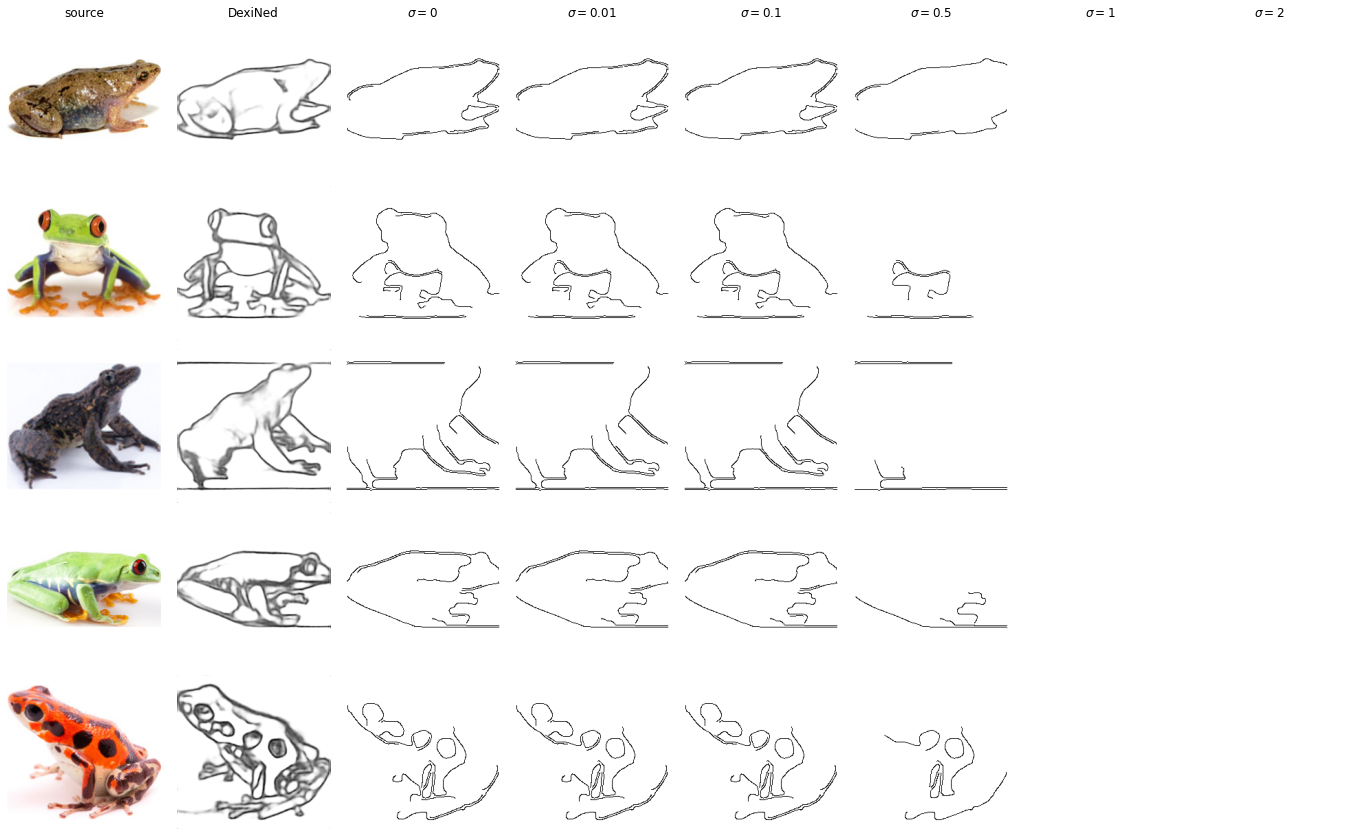

In [274]:
def print_canny_examples(n=3, sigmas=[1,3], size=2, canny_kw=None):
    
    canny_kw = {} if canny_kw is None else canny_kw
    
    #  plot results
    fig, axs = plt.subplots(n,2+len(sigmas), figsize=(size*(2+len(sigmas)), size*n))

    # each row is a new example
    for example in axs:
        
        # get a random image
        sketch_path = random.choice(filepaths)
        image_path = sketch_path.__str__().replace('interim\\DexiNed-fuse', 'raw\\data-224')

        sketch = plt.imread(sketch_path)
        image = plt.imread(image_path)

        example[0].imshow(image)
        example[1].imshow(sketch, cmap='gray')

        # perform canny filtering
        edges = [skimage.feature.canny(sketch, sigma=sigma, **canny_kw) for sigma in sigmas]      

        for i, ax in enumerate(example[2:]):
            ax.imshow(edges[i], cmap='gray_r')

        for ax in example:
            ax.axis('off')
            
    # add titles to top row
    axs[0][0].set_title('source')
    axs[0][1].set_title('DexiNed')
    for i, ax in enumerate(axs[0][2:]):
        ax.set_title(f'$\sigma={sigmas[i]}$')

    fig.patch.set_facecolor('white')      
    plt.subplots_adjust(wspace=0.1, hspace=0.)
    plt.show()

canny_kw = dict(
    high_threshold=3,
    low_threshold=1,
)

print_canny_examples(n=5, sigmas=[0, 0.01, 0.1, 0.5, 1, 2], size=3, canny_kw=canny_kw)

Finding a set of thresholds and a sigma that works consistently is very difficult. For now, let's use the DexiNed output as is to train a Pix2Pix model and see how well that works.